## Домашнее здание №2 / Link Prediction

### Медведева Анна, 399

----
План выполнения домашнего задания:

1. Краткий обзор исходных данных
2. Генерация дополнительных данных
3. Создание матрицы признаков для ребер
4. Настройка модели и валидация качества модели
5. Отправка результатов в контест на Kaggle

----

В данном домашнем задании вам предстоит построить классификатор, который бы предсказывал наличие или отсутствия ребра в графе между двумя вершинами. Никакой дополнительной информации о вершинах, кроме ее соседей нет, поэтому вам придется создавать вектор признаков для каждой пары вершин на основе топологии графа.

Вершины графа - товары интернет магазина, наличие ребра символизируют о высокой частоте совместной покупки данных товаров вместе. Например если в нашем графе присутствую вершины молоко и хлеб и данные товары часто покупаются вместе, то между данными вершинами будет ребро. Если в нашем графе есть вершины молоко и кроссовки, то между данными вершинами ребра не будет. 

В данном датасете уровень относительной частоты по которому решается есть ребро между вершинами или его нет был определен за нас. Сам датасет был получен краулингом сайта Amazon.com в марте 2003 года, парсилась секция "Люди которые купили данный продукт, также преобретали это..."

Мотивация данного задания: Расширить список блока рекомендаций, за счет товаров которые с высокой вероятность могут оказаться в одной корзине покупателя.

----
Для создания модели и работы с данными мы будем использовать пакет GraphLab, структуры данных SFrame и SGraph идеально подходят для работы с графами. Распределенное хранение данных и применения функций для расчета метрик отдельных вершин сильно облегчают работу с графом.

Библиотека платная, но лицензия для академических целей получается в течении 5 минут, чтобы установить пакет следуйте шагам на сайте - https://turi.com/download/academic.html

----

Описание файлов:

1. the_graph.csv - файл содержащий ребра графа, две колонки: src,dst 
2. suspicions.csv - файл с ребрами, графа. Для данных ребер неизвестно присутствует ли оно в графе или нет.

Описание целевой метрики - в качестве целевой метрики будем использовать ROC AUC http://mlwiki.org/index.php/ROC_Analysis

----

In [1]:
%pylab inline
import graphlab as gl
import numpy as np
import pandas as pd
from collections import defaultdict, deque
from random import randrange

gl.canvas.set_target('ipynb')

Populating the interactive namespace from numpy and matplotlib


### 1. Краткий обзор исходных данных - 10 Баллов

Загрузим данные, найдем ряд базовых статистик:

1. Количество вершин и ребер
2. Распределение степеней вершин графа (График log - log)
3. Плотность графа
4. Диаметр графа
5. Количество треугольников в графе
6. Краткие выводы о данных.
7. БОНУСЫ - сделайте красивую визулизацию или расчет дополнительных метрик с выводами и вы получите дополнительные баллы за задание

In [2]:
edges = gl.SFrame.read_csv('the_graph.csv', delimiter=',', verbose=False)

This non-commercial license of GraphLab Create for academic use is assigned to anna.medvedeva@phystech.edu and will expire on November 11, 2017.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1479243726.log


In [3]:
g = gl.SGraph().add_edges(edges, src_field='src', dst_field='dst')

1. Количество вершин и ребер

In [4]:
vert_edgs = g.summary()

print 'Number of vertices = {0}'.format(vert_edgs['num_vertices'])
print 'Number of edges = {0}'.format(vert_edgs['num_edges'])

Number of vertices = 262111
Number of edges = 1384871


Выполните пункты 2 - 6. В пункте 6 напишите краткие выводы.

2 Распределение степеней вершин графа (График log - log)

In [5]:
def load_graph(fname):
    g = defaultdict(set)
    
    with open(fname, 'r') as f:
        f.readline()
        for l in f:
            a, b = map(int, l.split(','))
            g[a].add(b)
            g[b].add(a)
    return g

G = load_graph('the_graph.csv')

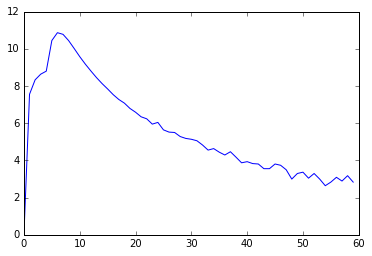

In [6]:
def plot_degrees(G):
    m = 60
    X = np.zeros(m, np.float32)
    for v in G:
        deg = len(G[v])
        if deg < m:
            X[deg] += 1
    plot(range(m), np.log(X + 1))

plot_degrees(G)

In [7]:
def number_of_edges(G):
    m = 0
    for v in G:
        m += len(G[v])
    return m / 2

In [8]:
def get_graph_density(G):
    n, m = len(G), number_of_edges(G)
    return 2.0 * m / (n * (n - 1))

print('Graph density: %.6f' % get_graph_density(G))

Graph density: 0.000031


In [9]:
def find_most_distant(G, f):
    q = deque()
    q.appendleft((f, 0))
    vis = [False] * len(G)
    max_dist = 0
    max_v = 0
    while len(q):
        v, d = q.pop()
        if vis[v]: continue
        vis[v] = True
        if d > max_dist:
            max_dist, max_v = d, v
        for vv in G[v]:
            q.appendleft((vv, d+1))
    return (max_v, max_dist)

def find_graph_diameter_approx(G):
    def diameter(G, v):
        v, d = find_most_distant(G, v)
        v, d = find_most_distant(G, v)
        return d
    return max([diameter(G, randrange(0, len(G))) for v in range(10)])

print('Graph diameter: %d' % find_graph_diameter_approx(G))

Graph diameter: 13


In [10]:
def count_triangles(G):
    vis = [0] * len(G)
    n = 0

    def dfs(G, v, vis, color, d, p):
        if d > 3:
            return 0
        if d == 3 and vis[v] == color:
            return 1
        if vis[v] == color:
            return 0
        vis[v] = color
        s = 0
        for vv in G[v]:
            if p != vv:
                s += dfs(G, vv, vis, color, d+1, v)
        return s

    for v in xrange(len(G)):
        n += dfs(G, v, vis, v, 0, -1)
    return n / 3

print('Number of triangles: %d' % count_triangles(G))

Number of triangles: 1791363


Граф является разряженным, т.к. количество ребер сравнимо с кол-вом вершин и плотность низкая.

Плотность низкая => вероятность наличия случайного ребра мала.

----
### 2. Генерация дополнительных данных - 20 Баллов

Перед нами стоит задача создания модели классификации, которая в дальнейшем будет использоваться для повышения разнообразия блока рекомендаций. Для большинства моделей классификации требуется минимум 2 класса объектов - негативный и позитивный. Но у нас есть только граф, ребра которые в нем присутствуют это позитивные примеры. Получается, что у нас нет негативных примеров. 

Ответьте на 3 вопроса:

1. Можем ли мы сами создать негативные примеры? Граф это описание связей между вершинами, если мы будем случайным образом выбирать две вершины и считать, что это ребро - негативный пример, имеет ли это смысл?
2. Если мы решим сгенерировать негативные примеры, как должна быть устроена процедура генерации, чтобы обобщаяющая способность модели была наилучшей?
3. Как зависит обобщающая способность модели от негативных примеров, которые мы ей покажем?

1. Да, можем. Негативный пример - отсутствие ребра.
2. Характеристики сгенерированных вершин должны иметь такое же распределение, как характеристики всех вершин.
3. Чем больше разнообразных негативных примеров, тем лучше обобщаюшая способность.

------
Создадим класс отрицательных примеров, сгенерировав его самым простым образом: берем две вершины, если ребро между ними отсутствует в графе, то это отрицательный пример.

1. Попробуйте улучшить генерацию отрицательных примеров

In [4]:
edges = gl.SFrame.read_csv('the_graph.csv', delimiter=',', verbose=False)
g = gl.SGraph().add_edges(edges, src_field='src', dst_field='dst')
vert_edgs = g.summary()

In [5]:
# read in existing edges
graph_file = open('the_graph.csv')
graph_file.readline() # first line is column names
existing_edges = set()

for x in graph_file:
    start, end = x.split(',')
    start, end = int(start), int(end)
    existing_edges.add((start, end))
    
print len(existing_edges)

1384871


In [5]:
# generating negative examples, so that class balance is 50/50 

PROPORTION = 1.
generated_nonexisting_edges = []
counter = 0
while True:
    start = np.random.randint(0, vert_edgs['num_vertices'])
    end = np.random.randint(0, vert_edgs['num_vertices'])

    if (start != end) & ((start, end) not in existing_edges):
        generated_nonexisting_edges.append([start, end, 0])

    counter += 1
    if counter == int(PROPORTION * vert_edgs['num_edges']):
        break

print len(generated_nonexisting_edges)

1384831


In [6]:
# create SFrame with negative examples
# generated_nonexisting_edges = pd.DataFrame(data=generated_nonexisting_edges, columns=['src', 'dst', 'class'])
# generated_nonexisting_edges = gl.SFrame(data=generated_nonexisting_edges)
edges = edges[:10000]
generated_nonexisting_edges = pd.DataFrame(data=generated_nonexisting_edges[:10000],
                                           columns=['src', 'dst', 'class'])
generated_nonexisting_edges = gl.SFrame(data=generated_nonexisting_edges[:10000])

In [7]:
# add target function to the original dataset 
edges['class'] = [1]*edges.shape[0]

In [8]:
# add negative examples to the main data and shuffle
edges = edges.append(generated_nonexisting_edges)
edges = gl.cross_validation.shuffle(edges)

In [9]:
# update our graph g with fake edges
g = gl.SGraph().add_edges(edges, src_field='src', dst_field='dst')

In [10]:
vert_edgs = g.summary()

print 'Number of vertices = {0}'.format(vert_edgs['num_vertices'])
print 'Number of edges = {0}'.format(vert_edgs['num_edges'])

Number of vertices = 36975
Number of edges = 20000


----
### 3. Создание матрицы признаков для ребер - 30 Баллов

Для создания модели классификации нам необходимы признаки, которые описывают каждое ребро. Вот базовый список того, что можно посчитать:

Для вершин:

1. Список и количество вершин, из которых ребра приходят в данную вершину
2. Список и количество вершин, в которые ребра приходят из данной вершины
3. Список и количество вершин связанных с данной вершиной
4. Список и количество вершин, которые связанны с данной вершиной как входящими, так и исходящими ребрами

Также можно добавить: вершины с которыми данная вершина образует треугольники, кластеризовать вершины и использовать кластер данной вершины и др.

Придумайте дополнительные интересные признаки для вершин и вы получите дополнительный балл за домашнюю работу!

In [5]:
all_vertices = g.get_vertices()
all_vertices.rename({"__id": "id"}) 
all_vertices.head(3)

id
5
7
8


In [6]:
def get_list(s):
    s = filter(lambda y: y != '', s[1:-1].split(', '))
    s =  map(int, s)
    return s

In [7]:
all_vert = pd.read_csv('all_vert.csv', converters={'out_vertices': get_list,
                                                  'in_vertices': get_list,
                                                  'both_vertices': get_list})
all_vertices = gl.SFrame(data=all_vert)
all_vert.index = all_vert['id']

In [8]:
all_vertices.head(2)

Columns:
	id	int
	out_vertices	array
	in_vertices	array
	in_degree	int
	out_degree	int
	second_in_degree	int
	second_out_degree	int
	both_vertices	array
	both_degree	int

Rows: 2

Data:
+--------+-------------------------------+-------------------------------+-----------+
|   id   |          out_vertices         |          in_vertices          | in_degree |
+--------+-------------------------------+-------------------------------+-----------+
| 251434 | [37011.0, 123425.0, 52759.... | [260166.0, 80999.0, 158383... |     11    |
| 211023 | [181032.0, 189713.0, 22438... | [78195.0, 248527.0, 205115... |     10    |
+--------+-------------------------------+-------------------------------+-----------+
+------------+------------------+-------------------+----------------------+-------------+
| out_degree | second_in_degree | second_out_degree |    both_vertices     | both_degree |
+------------+------------------+-------------------+----------------------+-------------+
|     11     |       123        |        120        | [250137.0, 255119.0] |      2      |
|     17     |        99        |        183        | [233626.0, 198886.0] |      2      |
+------------+------------------+-------------------+----------------------+-------------+
[2 rows x 9 columns]

In [9]:
all_vert.head(2)

,id,out_vertices,in_vertices,in_degree,out_degree,second_in_degree,second_out_degree,both_vertices,both_degree
id,,,,,,,,,
251434,251434,"[37011, 123425, 52759, 255119, 4126, 250137, 6...","[260166, 80999, 158383, 181225, 250137, 23464,...",11,11,123,120,"[250137, 255119]",2
211023,211023,"[181032, 189713, 224381, 2228, 159269, 192368,...","[78195, 248527, 205115, 150639, 236267, 87769,...",10,17,99,183,"[233626, 198886]",2


In [16]:
# calculating each vertices in and out connections
out_vertices = edges.groupby("src", {"out_vertices": gl.aggregate.CONCAT("dst")})
out_vertices.rename({"src": "id"})

in_vertices = edges.groupby("dst", {"in_vertices": gl.aggregate.CONCAT("src")})
in_vertices.rename({"dst": "id"})
print 

In [17]:
# join in and out connections with all_vertices
all_vertices = all_vertices.join(out_vertices, on="id", how="outer")
all_vertices = all_vertices.join(in_vertices, on="id", how="outer")

# replace missing values with empty lists
all_vertices = all_vertices.fillna('in_vertices',[])
all_vertices = all_vertices.fillna('out_vertices',[])
all_vertices.head(3)

RuntimeError: Runtime Exception. Default value must be convertible to column type

Мы получили базовый набор данных - список входящих и исходящих вершин, для каждой вершины. Теперь найдем количества вершин для метрик 1 и 2. Метрики 3 и 4 вы посчитаете сами

In [95]:
# in_degree - number of users following each vertex
all_vertices['in_degree'] = all_vertices["in_vertices"].apply(lambda x: len(x) )

# out_degree - number of users each vertex is following
all_vertices['out_degree'] = all_vertices["out_vertices"].apply(lambda x: len(x) )

In [39]:
all_vertices.head(3)

Columns:
	id	int
	out_vertices	array
	in_vertices	array
	in_degree	int
	out_degree	int
	second_in_degree	int
	second_out_degree	int
	both_vertices	array
	both_degree	int

Rows: 3

Data:
+--------+-------------------------------+-------------------------------+-----------+
|   id   |          out_vertices         |          in_vertices          | in_degree |
+--------+-------------------------------+-------------------------------+-----------+
| 251434 | [37011.0, 123425.0, 52759.... | [260166.0, 80999.0, 158383... |     11    |
| 211023 | [181032.0, 189713.0, 22438... | [78195.0, 248527.0, 205115... |     10    |
| 21855  | [163479.0, 25115.0, 5883.0... | [210796.0, 52985.0, 91031.... |     13    |
+--------+-------------------------------+-------------------------------+-----------+
+------------+------------------+-------------------+
| out_degree | second_in_degree | second_out_degree |
+------------+------------------+-------------------+
|     11     |       123        |        120        |
|     17     |        99        |        183        |
|     10     |       131        |         98        |
+------------+------------------+-------------------+
+-----------------------------+-------------+
|        both_vertices        | both_degree |
+-----------------------------+-------------+
|     [250137.0, 255119.0]    |      2      |
|     [233626.0, 198886.0]    |      2      |
| [15075.0, 25116.0, 21854.0] |      3      |
+-----------------------------+-------------+
[3 rows x 9 columns]

In [97]:
all_vert = all_vertices.to_dataframe()

In [98]:
set(all_vert.ix[1]['in_vertices'])

{94213, 103500, 130553, 198886, 209072, 214275, 233626, 236267, 248527}

In [99]:
def calc_second_degree(x, col_name='in_vertices'):
    sec_neighb = set()
    for neighb in x:
        sec_neighb = sec_neighb.union(set(all_vert.ix[neighb][col_name]))
    return len(sec_neighb)

In [100]:
all_vert['second_in_degree'] = all_vert['in_vertices'].apply(lambda x: calc_second_degree(x, 
                                                                                          col_name='in_vertices'))

Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/usr/lib/python2.7/inspect.py", line 1044, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/usr/lib/python2.7/inspect.py", line 1008, in getframeinfo
    lines, lnum = findsource(frame)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 182, in findsource
    lines = linecache.getlines(file, globals_dict)
  File "/usr/lib/python2.7/linecache.py", line 41, in getlines
    return updatecache(filena

IndexError: string index out of range

In [ ]:
all_vert['second_out_degree'] = all_vert['out_vertices'].apply(lambda x: calc_second_degree(x,
                                                                                            col_name='out_vertices'))

In [ ]:
def calc_common_vertices(x):
    x = all_vert.ix[x]
    return list(set(x['in_vertices']).intersection(x['out_vertices']))

In [ ]:
all_vert['both_vertices'] = all_vert['id'].apply(lambda x: calc_common_vertices(x))

In [ ]:
print set(all_vert.ix[251434, 'in_vertices']).intersection(all_vert.ix[251434, 'out_vertices'])
print all_vert.ix[251434, 'both_vertices']

In [ ]:
all_vert['both_degree'] = all_vert['both_vertices'].apply(lambda x: len(x))

In [ ]:
all_vert.to_csv('all_vert.csv')

In [ ]:
all_vertices['second_in_degree']= all_vert['second_in_degree']
all_vertices['second_out_degree']= all_vert['second_out_degree']
all_vertices['both_vertices'] = all_vert['both_vertices']
all_vertices['both_degree'] = all_vert['both_degree']

Мы получили характеристики для каждой вершины графа. Так как у нас задача предсказания наличия ребра, мы должны составить описание каждого ребра, используя метрики вершин. После составления характеристик ребер, мы можем перейти к генерации свойств ребер, взяв за основу метрики вершин ребра. Пример метрик для ребер, которые мы можем найти:

1. Общие друзья вершин ребра
2. Общее количество друзей вершин ребра
3. Коэффициенты Жаккара, Пирсона, Адамик - Адара, косинусная мера

Данные метрики находятся для каждого списка вершин, пунктов 1 - 4

In [6]:
%pylab inline
import graphlab as gl
import numpy as np
import pandas as pd
from collections import defaultdict, deque
from random import randrange

gl.canvas.set_target('ipynb')

Populating the interactive namespace from numpy and matplotlib


In [7]:
NUMB_OF_EDGES = 10000

edges = gl.SFrame.read_csv('the_graph.csv', delimiter=',', verbose=False)
#edges = edges[:NUMB_OF_EDGES]
g = gl.SGraph().add_edges(edges, src_field='src', dst_field='dst')
vert_edgs = g.summary()

graph_file = open('the_graph.csv')
graph_file.readline() # first line is column names
existing_edges = set()

for x in graph_file:
    start, end = x.split(',')
    start, end = int(start), int(end)
    existing_edges.add((start, end))
    
print len(existing_edges)


PROPORTION = 1.
generated_nonexisting_edges = []
counter = 0
while True:
    start = np.random.randint(0, vert_edgs['num_vertices'])
    end = np.random.randint(0, vert_edgs['num_vertices'])

    if (start != end) & ((start, end) not in existing_edges):
        generated_nonexisting_edges.append([start, end, 0])

    counter += 1
    if counter == int(PROPORTION * vert_edgs['num_edges']):
        break
edges['class'] = [1]*edges.shape[0]
print len(generated_nonexisting_edges)

1384871
1384835


In [8]:
generated_nonexisting_edges = pd.DataFrame(data=generated_nonexisting_edges,
                                           columns=['src', 'dst', 'class'])
generated_nonexisting_edges = gl.SFrame(data=generated_nonexisting_edges)
edges = edges.append(generated_nonexisting_edges)
edges = gl.cross_validation.shuffle(edges)

In [9]:
def get_list(s):
    s = filter(lambda y: y != '', s[1:-1].split(', '))
    s =  map(int, s)
    return s

In [10]:
all_vert = pd.read_csv('all_vert.csv', converters={'out_vertices': get_list,
                                                  'in_vertices': get_list,
                                                  'both_vertices': get_list})
all_vertices = gl.SFrame(data=all_vert)
all_vert.index = all_vert['id']

In [11]:
edges = edges.join(all_vertices, on={"src": "id"}, how="right")
edges.rename({"in_vertices": "src_in_vertices", "out_vertices": "src_out_vertices",
              "in_degree": "src_in_degree", "out_degree": "src_out_degree",
              'second_in_degree': 'src_second_in_degree', 
              'second_out_degree': 'src_second_out_degree', 
              'both_vertices' : 'src_both_vertices',
              'both_degree':'src_both_degree'})

edges = edges.join(all_vertices, on={"dst": "id"}, how="right")
edges.rename({"in_vertices": "dst_in_vertices", "out_vertices": "dst_out_vertices",
              "in_degree": "dst_in_degree",
              "out_degree": "dst_out_degree",
              'second_in_degree': 'dst_second_in_degree', 
              'second_out_degree': 'dst_second_out_degree', 
              'both_vertices' : 'dst_both_vertices',
              'both_degree':'dst_both_degree'})

edges.head(3)

Columns:
	src	int
	dst	int
	class	int
	src_out_vertices	array
	src_in_vertices	array
	src_in_degree	int
	src_out_degree	int
	src_second_in_degree	int
	src_second_out_degree	int
	src_both_vertices	array
	src_both_degree	int
	dst_out_vertices	array
	dst_in_vertices	array
	dst_in_degree	int
	dst_out_degree	int
	dst_second_in_degree	int
	dst_second_out_degree	int
	dst_both_vertices	array
	dst_both_degree	int

Rows: 3

Data:
+--------+--------+-------+-------------------------------+
|  src   |  dst   | class |        src_out_vertices       |
+--------+--------+-------+-------------------------------+
| 64786  | 82652  |   1   | [151592.0, 74929.0, 82651.... |
| 107963 | 177326 |   0   | [135094.0, 78031.0, 83174.... |
| 93925  | 215567 |   0   | [88513.0, 144411.0, 60680.... |
+--------+--------+-------+-------------------------------+
+-------------------------------+---------------+----------------+----------------------+
|        src_in_vertices        | src_in_degree | src_out_degree | src_second_in_degree |
+-------------------------------+---------------+----------------+----------------------+
| [60524.0, 116699.0, 63974.... |       10      |       8        |          89          |
| [169878.0, 3438.0, 123389.... |       13      |       11       |         152          |
| [88513.0, 192006.0, 176906... |       15      |       9        |         145          |
+-------------------------------+---------------+----------------+----------------------+
+-----------------------+-------------------------------+-----------------+
| src_second_out_degree |       src_both_vertices       | src_both_degree |
+-----------------------+-------------------------------+-----------------+
|           81          |  [82650.0, 82651.0, 63974.0]  |        3        |
|          126          |      [100856.0, 135094.0]     |        2        |
|           93          | [88513.0, 144411.0, 144412.0] |        3        |
+-----------------------+-------------------------------+-----------------+
+-------------------------------+-------------------------------+---------------+
|        dst_out_vertices       |        dst_in_vertices        | dst_in_degree |
+-------------------------------+-------------------------------+---------------+
| [90755.0, 247337.0, 74184.... | [64785.0, 13617.0, 90755.0... |       15      |
| [82270.0, 194084.0, 171524... | [220730.0, 171524.0, 19408... |       9       |
| [136063.0, 14711.0, 168601... | [205703.0, 79524.0, 42402.... |       7       |
+-------------------------------+-------------------------------+---------------+
+----------------+----------------------+-----------------------+
| dst_out_degree | dst_second_in_degree | dst_second_out_degree |
+----------------+----------------------+-----------------------+
|       8        |         137          |           74          |
|       10       |          84          |           97          |
|       12       |          76          |          140          |
+----------------+----------------------+-----------------------+
+-------------------------------+-----------------+
|       dst_both_vertices       | dst_both_degree |
+-------------------------------+-----------------+
| [74184.0, 74929.0, 90755.0... |        5        |
| [171524.0, 194083.0, 19408... |        4        |
|           [181169.0]          |        1        |
+-------------------------------+-----------------+
[3 rows x 19 columns]

Найдем пункт 1 - общих друзей для списков вершин из пункта 1. Пункты 2 и 3 вы посчитаете самостоятельно

In [12]:
def common_friends(u, v, u_neighbors, v_neighbors):
    
    if v_neighbors is None:
        v_neighbors = set()
        
    if u_neighbors is None:
        u_neighbors = set()
    
    u_neighbors = set(u_neighbors)
    if v in u_neighbors:
            u_neighbors.remove(v)

    v_neighbors = set(v_neighbors)
    if u in v_neighbors:
        v_neighbors.remove(u)
        
    return len(u_neighbors & v_neighbors)

In [13]:
def common_friends_list(u, v, u_neighbors, v_neighbors):
    if v_neighbors is None:
        v_neighbors = set()
        
    if u_neighbors is None:
        u_neighbors = set()
    
    u_neighbors = set(u_neighbors)
    if v in u_neighbors:
            u_neighbors.remove(v)

    v_neighbors = set(v_neighbors)
    if u in v_neighbors:
        v_neighbors.remove(u)
        
    return list(u_neighbors & v_neighbors)

In [14]:
edges['common_in_vertices'] = (edges[['src','dst', 'src_in_vertices', 'dst_in_vertices']]
                               .apply(lambda x: common_friends(x['src'], x['dst'],
                                                               x['src_in_vertices'], x['dst_in_vertices'])))

In [26]:
edges['common_in_vertices_list'] = (edges[['src','dst', 'src_in_vertices', 'dst_in_vertices']]
                               .apply(lambda x: common_friends_list(x['src'], x['dst'],x['src_in_vertices'], x['dst_in_vertices'])))

In [15]:
edges['common_out_vertices'] = (edges[['src','dst', 'src_out_vertices', 'dst_out_vertices']]
                               .apply(lambda x: common_friends(x['src'], x['dst'],x['src_out_vertices'],
                                                               x['dst_out_vertices'])))

In [27]:
edges['common_out_vertices_list'] = (edges[['src','dst', 'src_out_vertices', 'dst_out_vertices']]
                               .apply(lambda x: common_friends_list(x['src'], x['dst'],x['src_out_vertices'],
                                                               x['dst_out_vertices'])))

In [16]:
def calc_jakar(u, v, u_neighbors, v_neighbors, common_neighbors):
    u_neighbors = set(u_neighbors)
    if v in u_neighbors:
            u_neighbors.remove(v)

    v_neighbors = set(v_neighbors)
    if u in v_neighbors:
        v_neighbors.remove(u)
    neighb = u_neighbors.union(v_neighbors)
    return common_neighbors * 1. / len(neighb)

In [17]:
edges['jakar_coef_in'] = (edges['src','dst', 'src_in_vertices', 'dst_in_vertices', 'common_in_vertices']
                          .apply(lambda x: calc_jakar(x['src'], x['dst'],
                                                      x['src_in_vertices'],
                                                      x['dst_in_vertices'],
                                                      x['common_in_vertices'])))

In [18]:
edges['jakar_coef_out'] = (edges['src','dst','src_out_vertices', 'dst_out_vertices', 'common_out_vertices']
                          .apply(lambda x: calc_jakar(x['src'], x['dst'],
                                                      x['src_out_vertices'],
                                                      x['dst_out_vertices'],
                                                      x['common_out_vertices'])))

In [19]:
edges.head(6)

Columns:
	src	int
	dst	int
	class	int
	src_out_vertices	array
	src_in_vertices	array
	src_in_degree	int
	src_out_degree	int
	src_second_in_degree	int
	src_second_out_degree	int
	src_both_vertices	array
	src_both_degree	int
	dst_out_vertices	array
	dst_in_vertices	array
	dst_in_degree	int
	dst_out_degree	int
	dst_second_in_degree	int
	dst_second_out_degree	int
	dst_both_vertices	array
	dst_both_degree	int
	common_in_vertices	int
	common_out_vertices	int
	jakar_coef_in	float
	jakar_coef_out	float

Rows: 6

Data:
+--------+--------+-------+-------------------------------+
|  src   |  dst   | class |        src_out_vertices       |
+--------+--------+-------+-------------------------------+
| 64786  | 82652  |   1   | [151592.0, 74929.0, 82651.... |
| 107963 | 177326 |   0   | [135094.0, 78031.0, 83174.... |
| 93925  | 215567 |   0   | [88513.0, 144411.0, 60680.... |
| 211622 | 63149  |   0   | [203794.0, 143866.0, 20607... |
| 216123 | 172095 |   1   | [73005.0, 202160.0, 157476... |
| 18457  | 18455  |   1   | [210271.0, 18455.0, 155379... |
+--------+--------+-------+-------------------------------+
+-------------------------------+---------------+----------------+----------------------+
|        src_in_vertices        | src_in_degree | src_out_degree | src_second_in_degree |
+-------------------------------+---------------+----------------+----------------------+
| [60524.0, 116699.0, 63974.... |       10      |       8        |          89          |
| [169878.0, 3438.0, 123389.... |       13      |       11       |         152          |
| [88513.0, 192006.0, 176906... |       15      |       9        |         145          |
| [258215.0, 224861.0, 88860... |       13      |       14       |         132          |
| [75203.0, 188813.0, 202161... |       6       |       15       |          78          |
| [227867.0, 95461.0, 88601.... |       11      |       10       |         108          |
+-------------------------------+---------------+----------------+----------------------+
+-----------------------+-------------------------------+-----------------+
| src_second_out_degree |       src_both_vertices       | src_both_degree |
+-----------------------+-------------------------------+-----------------+
|           81          |  [82650.0, 82651.0, 63974.0]  |        3        |
|          126          |      [100856.0, 135094.0]     |        2        |
|           93          | [88513.0, 144411.0, 144412.0] |        3        |
|          129          | [208673.0, 208669.0, 22486... |        4        |
|          146          |      [202160.0, 202161.0]     |        2        |
|          104          | [18456.0, 17457.0, 34242.0... |        4        |
+-----------------------+-------------------------------+-----------------+
+-------------------------------+-------------------------------+---------------+
|        dst_out_vertices       |        dst_in_vertices        | dst_in_degree |
+-------------------------------+-------------------------------+---------------+
| [90755.0, 247337.0, 74184.... | [64785.0, 13617.0, 90755.0... |       15      |
| [82270.0, 194084.0, 171524... | [220730.0, 171524.0, 19408... |       9       |
| [136063.0, 14711.0, 168601... | [205703.0, 79524.0, 42402.... |       7       |
| [63148.0, 47744.0, 237845.... | [56991.0, 218660.0, 102322... |       8       |
| [9693.0, 172177.0, 182844.... | [172179.0, 170531.0, 15035... |       10      |
| [3498.0, 17459.0, 91069.0,... | [131202.0, 18457.0, 17457.... |       13      |
+-------------------------------+-------------------------------+---------------+
+----------------+----------------------+-----------------------+
| dst_out_degree | dst_second_in_degree | dst_second_out_degree |
+----------------+----------------------+-----------------------+
|       8        |         137          |           74          |
|       10       |          84          |           97          |
|       12       |          76          |          140          |
|       

In [20]:
def total_friends(u, v, u_neighbors, v_neighbors):
    if u_neighbors is None:
        u_neighbors = set()
        
    if v_neighbors is None:
        v_neighbors = set()

    u_neighbors = set(u_neighbors)
    if v in u_neighbors:
            u_neighbors.remove(v)

    v_neighbors = set(v_neighbors)
    if u in v_neighbors:
        v_neighbors.remove(u)
    neighb = u_neighbors.union(v_neighbors)
    return len(neighb)

In [21]:
edges['total_in_vertices'] = (edges[['src','dst', 'src_in_vertices', 'dst_in_vertices']]
                               .apply(lambda x: total_friends(x['src'], x['dst'], 
                                                              x['src_in_vertices'], x['dst_in_vertices'])))

In [22]:
edges['total_out_vertices'] = (edges[['src','dst', 'src_out_vertices', 'dst_out_vertices']]
                               .apply(lambda x: total_friends(x['src'], x['dst'],x['src_out_vertices'],
                                                               x['dst_out_vertices'])))

In [23]:
edges[['class', 'common_in_vertices', 'total_in_vertices','jakar_coef_in']].tail(2)

class,common_in_vertices,total_in_vertices,jakar_coef_in
0,0,34,0.0
1,0,20,0.0


In [28]:
def calc_adamik(u, v, neib, direction='in_degree'):
    #print neib
    sec_neighb = np.array(all_vert.ix[neib][direction])
    #print u, v, sec_neighb
    #print sec_neighb
    adamik = -np.log(sec_neighb).sum()
    del sec_neighb
    return adamik

In [29]:
edges['adamik_in'] = (edges[['src','dst', 'common_in_vertices_list']]
                      .apply(lambda x: calc_adamik(x['src'], x['dst'],
                                                   x['common_in_vertices_list'], direction='in_degree')))

In [23]:
edges['adamik_out'] = (edges[['src','dst', 'common_out_vertices_list']]
                      .apply(lambda x: calc_adamik(x['src'], x['dst'],
                                                   x['common_out_vertices_list'], direction='out_degree')))

In [31]:
edges.head(2)

Columns:
	src	int
	dst	int
	class	int
	src_out_vertices	array
	src_in_vertices	array
	src_in_degree	int
	src_out_degree	int
	src_second_in_degree	int
	src_second_out_degree	int
	src_both_vertices	array
	src_both_degree	int
	dst_out_vertices	array
	dst_in_vertices	array
	dst_in_degree	int
	dst_out_degree	int
	dst_second_in_degree	int
	dst_second_out_degree	int
	dst_both_vertices	array
	dst_both_degree	int
	common_in_vertices	int
	common_out_vertices	int
	jakar_coef_in	float
	jakar_coef_out	float
	total_in_vertices	int
	total_out_vertices	int
	common_in_vertices_list	array
	common_out_vertices_list	array
	adamik_in	float
	adamik_out	float

Rows: 2

Data:
+--------+--------+-------+-------------------------------+
|  src   |  dst   | class |        src_out_vertices       |
+--------+--------+-------+-------------------------------+
| 64786  | 82652  |   1   | [151592.0, 74929.0, 82651.... |
| 107963 | 177326 |   0   | [135094.0, 78031.0, 83174.... |
+--------+--------+-------+-------------------------------+
+-------------------------------+---------------+----------------+----------------------+
|        src_in_vertices        | src_in_degree | src_out_degree | src_second_in_degree |
+-------------------------------+---------------+----------------+----------------------+
| [60524.0, 116699.0, 63974.... |       10      |       8        |          89          |
| [169878.0, 3438.0, 123389.... |       13      |       11       |         152          |
+-------------------------------+---------------+----------------+----------------------+
+-----------------------+-----------------------------+-----------------+
| src_second_out_degree |      src_both_vertices      | src_both_degree |
+-----------------------+-----------------------------+-----------------+
|           81          | [82650.0, 82651.0, 63974.0] |        3        |
|          126          |     [100856.0, 135094.0]    |        2        |
+-----------------------+-----------------------------+-----------------+
+-------------------------------+-------------------------------+---------------+
|        dst_out_vertices       |        dst_in_vertices        | dst_in_degree |
+-------------------------------+-------------------------------+---------------+
| [90755.0, 247337.0, 74184.... | [64785.0, 13617.0, 90755.0... |       15      |
| [82270.0, 194084.0, 171524... | [220730.0, 171524.0, 19408... |       9       |
+-------------------------------+-------------------------------+---------------+
+----------------+----------------------+-----------------------+
| dst_out_degree | dst_second_in_degree | dst_second_out_degree |
+----------------+----------------------+-----------------------+
|       8        |         137          |           74          |
|       10       |          84          |           97          |
+----------------+----------------------+-----------------------+
+-------------------------------+-----------------+--------------------+-----+
|       dst_both_vertices       | dst_both_degree | common_in_vertices | ... |
+-------------------------------+-----------------+--------------------+-----+
| [74184.0, 74929.0, 90755.0... |        5        |         1          | ... |
| [171524.0, 194083.0, 19408... |        4        |         0          | ... |
+-------------------------------+-----------------+--------------------+-----+
[2 rows x 29 columns]

In [ ]:
edges.save('edges')

Результатом пункта 3 является матрица признаков. Теперь мы готовы занятся настройкой моделей. Главная ваша задача в пункте 3 - подготовить как можно больше качественных признаков, которые могли бы использоваться для настройки модели машинного обучения.

----
### 4. Настройка модели и валидация качества модели - 20 Баллов

Исключим подозрительные ребра из рассмотрения, а затем разобьем датасет на 2 части, для обучения и проверки результатов. Настроим базовую модель классификации - логистическую регрессию.
Для улучшения качества модели вам предстоит выполнить следующие пункты:

1. Кросс - валидация для настройки гиперпараметров модели и регуляризации
2. Подбор модели машинного обучения (случайный лес, бустинг, нейронная сеть и т.д.)

In [32]:
len(edges)

2769706

In [33]:
susp = gl.SFrame.read_csv('suspicions.csv', delimiter=',', verbose=False)
print susp.shape

(299994, 3)


In [52]:
edges = edges.fillna('src_in_vertices', array([]))
edges = edges.fillna('src_out_vertices', array([]))
edges = edges.fillna('dst_in_vertices', array([]))
edges = edges.fillna('dst_out_vertices', array([]))

In [ ]:
print edges.shape
edges = edges.join(susp, on=['src', 'dst'], how='left')
print edges.shape

(2769706, 29)


In [22]:
edges.head(2)

Columns:
	src	int
	dst	int
	class	int
	src_out_vertices	array
	src_in_vertices	array
	src_in_degree	int
	src_out_degree	int
	src_second_in_degree	int
	src_second_out_degree	int
	src_both_vertices	array
	src_both_degree	int
	dst_out_vertices	array
	dst_in_vertices	array
	dst_in_degree	int
	dst_out_degree	int
	dst_second_in_degree	int
	dst_second_out_degree	int
	dst_both_vertices	array
	dst_both_degree	int
	common_in_vertices	int
	common_out_vertices	int
	jakar_coef_in	float
	jakar_coef_out	float
	total_in_vertices	int
	total_out_vertices	int
	edge_id	int

Rows: 2

Data:
+--------+--------+-------+-------------------------------+
|  src   |  dst   | class |        src_out_vertices       |
+--------+--------+-------+-------------------------------+
| 162239 | 253224 |   0   | [192401.0, 114647.0, 13995... |
| 177127 | 244103 |   0   | [161263.0, 185216.0, 33651... |
+--------+--------+-------+-------------------------------+
+-------------------------------+---------------+----------------+----------------------+
|        src_in_vertices        | src_in_degree | src_out_degree | src_second_in_degree |
+-------------------------------+---------------+----------------+----------------------+
| [66355.0, 78254.0, 170630.... |       7       |       12       |          98          |
| [84368.0, 14732.0, 218974.... |       7       |       6        |          83          |
+-------------------------------+---------------+----------------+----------------------+
+-----------------------+----------------------+-----------------+
| src_second_out_degree |  src_both_vertices   | src_both_degree |
+-----------------------+----------------------+-----------------+
|          138          |      [114602.0]      |        1        |
|           38          | [161264.0, 161263.0] |        2        |
+-----------------------+----------------------+-----------------+
+-------------------------------+-------------------------------+---------------+
|        dst_out_vertices       |        dst_in_vertices        | dst_in_degree |
+-------------------------------+-------------------------------+---------------+
| [247975.0, 4896.0, 188496.... | [250207.0, 183931.0, 11268... |       5       |
| [42208.0, 42132.0, 73644.0... | [133430.0, 218899.0, 23381... |       7       |
+-------------------------------+-------------------------------+---------------+
+----------------+----------------------+-----------------------+-------------------+
| dst_out_degree | dst_second_in_degree | dst_second_out_degree | dst_both_vertices |
+----------------+----------------------+-----------------------+-------------------+
|       11       |          52          |          112          |         []        |
|       7        |          59          |           46          |         []        |
+----------------+----------------------+-----------------------+-------------------+
+-----------------+--------------------+-----+
| dst_both_degree | common_in_vertices | ... |
+-----------------+--------------------+-----+
|        0        |         0          | ... |
|        0        |         0          | ... |
+-----------------+--------------------+-----+
[2 rows x 26 columns]

In [ ]:
clean_edges = edges[edges['edge_id'] == None]
susp_edges = edges[edges['edge_id'] != None]
print clean_edges.shape, susp_edges.shape

In [ ]:
clean_edges.remove_column('edge_id')
print

In [25]:
clean_edges.head(3)

Columns:
	src	int
	dst	int
	class	int
	src_out_vertices	array
	src_in_vertices	array
	src_in_degree	int
	src_out_degree	int
	src_second_in_degree	int
	src_second_out_degree	int
	src_both_vertices	array
	src_both_degree	int
	dst_out_vertices	array
	dst_in_vertices	array
	dst_in_degree	int
	dst_out_degree	int
	dst_second_in_degree	int
	dst_second_out_degree	int
	dst_both_vertices	array
	dst_both_degree	int
	common_in_vertices	int
	common_out_vertices	int
	jakar_coef_in	float
	jakar_coef_out	float
	total_in_vertices	int
	total_out_vertices	int

Rows: 3

Data:
+--------+--------+-------+-------------------------------+
|  src   |  dst   | class |        src_out_vertices       |
+--------+--------+-------+-------------------------------+
| 162239 | 253224 |   0   | [192401.0, 114647.0, 13995... |
| 177127 | 244103 |   0   | [161263.0, 185216.0, 33651... |
| 239830 | 239831 |   1   | [217402.0, 50255.0, 239832... |
+--------+--------+-------+-------------------------------+
+-------------------------------+---------------+----------------+----------------------+
|        src_in_vertices        | src_in_degree | src_out_degree | src_second_in_degree |
+-------------------------------+---------------+----------------+----------------------+
| [66355.0, 78254.0, 170630.... |       7       |       12       |          98          |
| [84368.0, 14732.0, 218974.... |       7       |       6        |          83          |
| [243564.0, 153197.0, 22981... |       8       |       13       |          75          |
+-------------------------------+---------------+----------------+----------------------+
+-----------------------+--------------------------------+-----------------+
| src_second_out_degree |       src_both_vertices        | src_both_degree |
+-----------------------+--------------------------------+-----------------+
|          138          |           [114602.0]           |        1        |
|           38          |      [161264.0, 161263.0]      |        2        |
|          136          | [233162.0, 243564.0, 239831.0] |        3        |
+-----------------------+--------------------------------+-----------------+
+-------------------------------+-------------------------------+---------------+
|        dst_out_vertices       |        dst_in_vertices        | dst_in_degree |
+-------------------------------+-------------------------------+---------------+
| [247975.0, 4896.0, 188496.... | [250207.0, 183931.0, 11268... |       5       |
| [42208.0, 42132.0, 73644.0... | [133430.0, 218899.0, 23381... |       7       |
| [233162.0, 239832.0, 17155... | [102377.0, 233162.0, 23815... |       9       |
+-------------------------------+-------------------------------+---------------+
+----------------+----------------------+-----------------------+
| dst_out_degree | dst_second_in_degree | dst_second_out_degree |
+----------------+----------------------+-----------------------+
|       11       |          52          |          112          |
|       7        |          59          |           46          |
|       15       |          90          |          161          |
+----------------+----------------------+-----------------------+
+--------------------------------+-----------------+--------------------+-----+
|       dst_both_vertices        | dst_both_degree | common_in_vertices | ... |
+--------------------------------+-----------------+--------------------+-----+
|               []               |        0        |         0          | ... |
|               []               |        0        |         0          | ... |
| [233162.0, 243564.0, 239830.0] |        3        |         2          | ... |
+--------------------------------+-----------------+--------------------+-----+
[3 rows x 25 columns]

In [ ]:
# split on train and test
#edges = gl.cross_validation.shuffle(edges)
test, train = clean_edges.random_split(0.2)

In [39]:
print test.shape, train.shape

(493515, 25) (1976188, 25)


In [ ]:
features = [
#'src',
# 'dst',
 #'src_out_vertices',
 #'src_in_vertices',
 'src_in_degree',
 'src_out_degree',
 'src_second_in_degree',
 'src_second_out_degree',
 #'src_both_vertices',
 'src_both_degree',
 #'dst_out_vertices',
 #'dst_in_vertices',
 'dst_in_degree',
 'dst_out_degree',
 'dst_second_in_degree',
 'dst_second_out_degree',
 #'dst_both_vertices',
 'dst_both_degree',
 'common_in_vertices',
 #'common_in_vertices_list',
 'common_out_vertices',
 #'common_out_vertices_list',
 'jakar_coef_in',
 'jakar_coef_out',
 'total_in_vertices',
'total_out_vertices',
'adamik_in',
'adamik_out']

In [ ]:
# fit basic classification model - LR
model = gl.classifier.logistic_classifier.create(train, 
                                                 target="class", 
                                                 #class_weights={1:0.9,0:0.1},
                                                 features=features,
                                                 max_iterations=60)
results = model.evaluate(test)
print results

In [92]:
model.coefficients.sort('value').print_rows(num_rows=40)

+-----------------------+-------+-------+-------------------+-------------------+
|          name         | index | class |       value       |       stderr      |
+-----------------------+-------+-------+-------------------+-------------------+
|     jakar_coef_out    |  None |   1   |   -10.8067570211  |   20.3602737984   |
|   total_out_vertices  |  None |   1   |   -9.4034658579   |   0.247992773627  |
|      (intercept)      |  None |   1   |   -7.12321254676  |   0.330154648544  |
|  common_out_vertices  |  None |   1   |   -6.64117967147  |   1.12200056682   |
|   total_in_vertices   |  None |   1   |   -5.47869353737  |   0.232898423589  |
|   common_in_vertices  |  None |   1   |   -4.39602665687  |   0.422216072632  |
|    src_both_degree    |  None |   1   |  -0.313199776996  |  0.0491299847896  |
|  dst_second_in_degree |  None |   1   | 0.000197600728838 | 0.000782003540291 |
|  src_second_in_degree |  None |   1   | 0.000931010810609 |  0.00238552579452 |
| dst_second_out

Мы получили базовую модель с метриками: точность ~ 0.67, ROC AUC ~ 0.71. Ваша задача улучшить модель,  за счет добавления новых признаков вершин, ребер и аккуратного обучения выбранных моделей (настройки гиперпараметров и регуляризации).

----
### 5. Отправка результатов в контест на Kaggle - 20 Баллов


Завершая домашнюю работу, нам небходимо предсказать вероятности наличия ребер, для заданного списка ребер. Результат отправлется в контест на kaggle.com в формате: edge_id - probability

In [99]:
predicted = model.predict(susp_edges, output_type='class')

In [73]:
susp_edges['probability'] = predicted

In [74]:
result = susp_edges['edge_id', 'probability']

In [101]:
result.save('result_classes.csv', format='csv')

In [99]:
h = hist(predicted, bins=100)

KeyboardInterrupt: 

ERROR! Session/line number was not unique in database. History logging moved to new session 1261


5

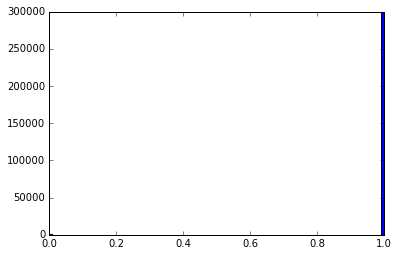

In [100]:
(predicted < 0.5).sum()

(array([ 414871.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,  325590.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

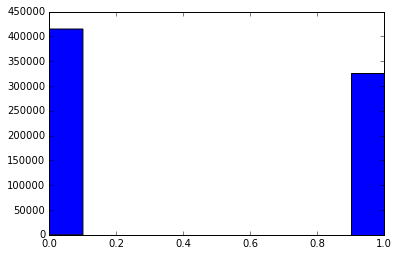

In [87]:
hist(test['class'])

----

----
### Не модифицируйте данный код, он для проверки вашего ноутбука

In [45]:
#from sklearn.metrics import roc_curve, auc
#import matplotlib.pyplot as plt
#%matplotlib inline

In [36]:
# labeled = pd.read_csv('labeled_suspicions.csv')
# print labeled.shape

# res = labeled.merge(result.to_dataframe(), on='edge_id', how='inner')
# res = res[['class', 'probability']]
# print res.shape

In [37]:
# fpr, tpr, _ = roc_curve(res['class'], res['probability'])
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(15, 10))
# lw = 2
# plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()